In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:01<00:00, 5119845.59it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 134320.90it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:01<00:00, 1275209.60it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5383025.93it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv0_drop = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_drop = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        self.conv3_drop = nn.Dropout2d(0.25)
        self.fc = nn.Linear(12544, 1)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.leaky_relu(self.conv0(x), 0.2)
        x = self.conv0_drop(x)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = self.conv1_drop(x)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = self.conv2_drop(x)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = self.conv3_drop(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s

        return num_features

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(100, 256*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.trans_conv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv4 = nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 7, 7)
        x = F.relu(self.trans_conv1(x))
        x = F.relu(self.trans_conv2(x))
        x = F.relu(self.trans_conv3(x))
        x = self.trans_conv4(x)
        x = torch.tanh(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device using: {device}")
D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

Device using: cuda


Generator(
  (fc): Linear(in_features=100, out_features=12544, bias=True)
  (trans_conv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (trans_conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (trans_conv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (trans_conv4): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)

In [20]:
def generate_noise(batch_size, dim):
    return torch.rand(batch_size, dim) * 2 - 1

In [ ]:
Loss = nn.BCEWithLogitsLoss()

def discriminator_real_loss(real_out):
    real_label = torch.ones(real_out.size()[0], 1).to(device)
    real_loss = Loss(real_out.squeeze(), real_label.squeeze())
    return real_loss

def discriminator_fake_loss(fake_out):
    fake_label = torch.zeros(fake_out.size()[0], 1).to(device)
    fake_loss = Loss(fake_out.squeeze(), fake_label.squeeze())
    return fake_loss

def discriminator_loss(real_out, fake_out):
    real_loss = discriminator_real_loss(real_out)
    fake_loss = discriminator_fake_loss(fake_out)
    total_loss = (real_loss + fake_loss)
    return total_loss

def generator_loss(gen_disc_out):
    label = torch.ones(gen_disc_out.size()[0], 1).to(device)
    gen_loss = Loss(gen_disc_out.squeeze(), label.squeeze())
    return gen_loss

In [ ]:
disc_opt = optim.Adam(D.parameters(), lr = 0.0002, betas = (0.5, 0.999))
gen_opt = optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [ ]:
def train(D, G, disc_opt, gen_opt, train_dl, batch_size = 32, epochs = 25, gen_input_size = 100):

    disc_losses = []
    gen_losses = []
    sample_size = 16
    fixed_samples = generate_noise(sample_size, gen_input_size)
    fixed_samples = fixed_samples.to(device)
    D.train()
    G.train()

    for epoch in range(epochs + 1):
        disc_loss_total = 0
        gen_loss_total = 0
        gen_out = 0
        for train_x, y in train_dl:
            disc_opt.zero_grad()
            train_x = train_x*2 - 1
            train_x = train_x.to(device)
            real_out = D(train_x.float())
            disc_gen_in = generate_noise(batch_size, gen_input_size)
            disc_gen_in = disc_gen_in.to(device)
            disc_gen_out = G(disc_gen_in.float()).detach()
            fake_out = D(disc_gen_out.float())
            disc_loss = discriminator_loss(real_out, fake_out)
            disc_loss_total += disc_loss
            disc_loss.backward()
            disc_opt.step()
            gen_opt.zero_grad()
            gen_out = G(disc_gen_in.float())
            gen_disc_out = D(gen_out.float())

            gen_loss = generator_loss(gen_disc_out)
            gen_loss_total += gen_loss
            gen_loss.backward()
            gen_opt.step()

        disc_losses.append(disc_loss_total)
        gen_losses.append(gen_loss_total)
        print("Epoch ", epoch, ": Discriminator Loss = ", disc_loss_total/len(train_dl), ", Generator Loss = ", gen_loss_total/len(train_dl))
    return disc_losses, gen_losses

In [ ]:
disc_losses, gen_losses = train(D, G, disc_opt, gen_opt, trainloader, batch_size=16)

Epoch  0 : Discriminator Loss =  tensor(0.0120, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(11.5050, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  1 : Discriminator Loss =  tensor(0.0037, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(14.7734, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  2 : Discriminator Loss =  tensor(2.5528e-06, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(19.3135, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  3 : Discriminator Loss =  tensor(2.1893e-06, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(22.8452, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  4 : Discriminator Loss =  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(28.1267, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  5 : Discriminator Loss =  tensor(2.4710e-06, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(31.7349, device='cuda:0', grad_fn=<DivBack

In [21]:
# Generate samples
sample_size = 16
noise = generate_noise(sample_size, 100).to(device)
samples = G(noise.float())

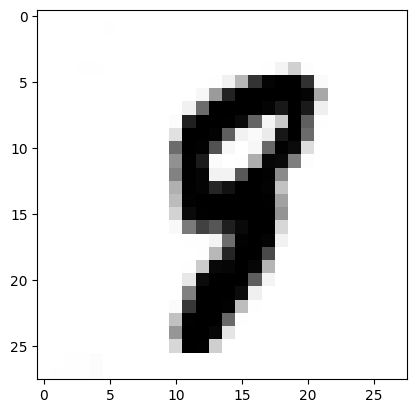

In [24]:
plt.imshow(samples[0].cpu().detach().numpy().reshape(28,28), cmap="Greys")
plt.show()